# Analysis of BR process for a Mean-Field Team

In [78]:
import itertools
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

from br_graph_analysis import learn_br_graph, transition_matrix_from_br_graph
import br_graph_analysis

### Mean-field Set up

First, we define the mean-field team problem. There are two states and two actions each agent can take. The reward is only a function of the state; it is 1 if the state is 1 and 0 if the state is 0. The transition kernel is such that the team will switch states if the majority votes for it, and won't otherwise. An optimal solution is one where a majority votes to switch states when in state 0, and only at most a minority votes to switch states when in state 1.

In [2]:
# MEAN-FIELD PARAMETERS
n_states = 2 # number of states
n_actions_const = 2 # all agents have the same action spaces

def get_initial_state():
    # initial state distribution
    return np.random.choice(range(n_states)) # uniform over states for now 
init_state = 0

def transition_state(x, us):
    '''returns next state given current state and action'''
    
    # switches state if majority of agents "affirm"
    mean_u = np.average(us)
    if mean_u > 0.5:
        return (x+1)%2
    else:
        return x

def mf_reward(x, u_i, mean_u):
    return float(x==1) # state 1 is desirable

def gen_reward_i(i):
    def reward_i(state, actions):
        ui = actions[i]
        mean_u = np.average(actions)
        return mf_reward(state, ui, mean_u)
    
    return reward_i

beta_const = 0.9 # discount rate; constant across agents

## Analysis for $N$ agents 

### $N = 2$

#### Learn Best-Reply Graph

In [28]:
n_agents = 2

# GAME PARAMS (adjusted for n-agents)
n_Us = [n_actions_const] * n_agents # number of actions per agent (both agents have two actions)
reward_funcs = [gen_reward_i(i) for i in range(n_agents)]
betas = [beta_const]*n_agents # discount factor

# LEARNING PARAMETERS
T = 10000 # length of exploration phase
experimentation_probs = [0.05]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-6]*n_agents # tolerance for suboptimality

In [5]:
br_graph2 = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.64s/it]


Draw the best-reply graph. For $N=2$, the joint policy space has 16 policies. Note that in this case, there is only one equilibrium: ((1,0), (1,0)), and it is the only sink in the BR graph below.

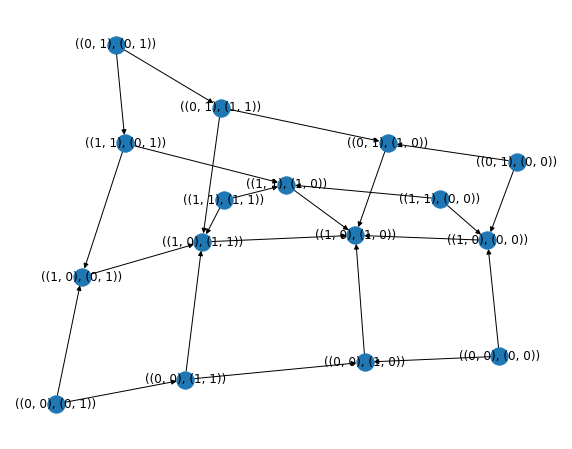

In [26]:
# draw BR graph (without self-loops)
br_graph_ = nx.DiGraph.copy(br_graph)
br_graph_.remove_edges_from(nx.selfloop_edges(br_graph_))
fig, ax = plt.subplots(figsize=(10,8))
nx.draw_spectral(br_graph_, with_labels=True, ax=ax)

#### Compute Transition Matrix from Best-Reply Graph

In [30]:
# BR Process PARAMETERS
agent_inertias = [0.5]*n_agents

agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))

In [31]:
transition_matrix, jps_dict = transition_matrix_from_br_graph(br_graph2, agent_inertias, joint_policy_space)
transition_matrix # confirmed with simulation of full q-learning algorithm

array([[0.25, 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.25,
        0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  ,
        0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 ,
        0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25,
        0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.25, 0.  , 0.25, 0.  , 0.25,
        0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.25, 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.25, 0.  , 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.5 ,
        0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25,
        0.25, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.5 ,
        0.  , 0.  , 0.

Compute the probability of converging to each policy from each starting policy.

In [32]:
final_state_probs = np.round(np.linalg.matrix_power(transition_matrix, 100), 4)
final_state_probs

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,

Since for $N=2$ there is only one equilibrium, the BR process will always converge to it w.p. 1 regardless of what the starting policy is.

### $N=3$

Do the same for $N=3,4,5$

#### Learn Best-Reply Graph

In [116]:
n_agents = 3

# GAME PARAMS (adjusted for n-agents)
n_Us = [n_actions_const] * n_agents # number of actions per agent (both agents have two actions)
reward_funcs = [gen_reward_i(i) for i in range(n_agents)]
betas = [beta_const]*n_agents # discount factor

# LEARNING PARAMETERS
T = 10000 # length of exploration phase
experimentation_probs = [0.05]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-6]*n_agents # tolerance for suboptimality

In [117]:
br_graph3 = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [02:56<00:00,  2.76s/it]


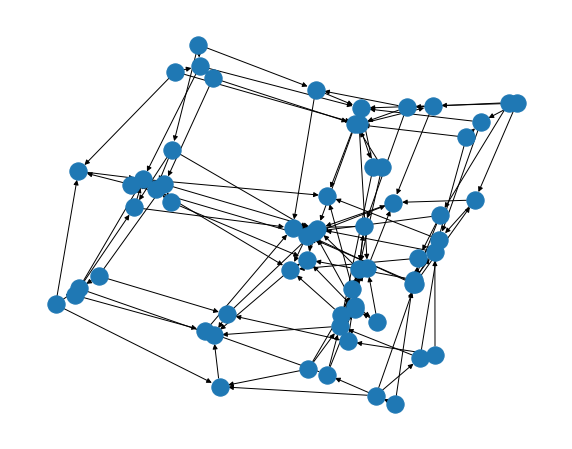

In [118]:
# draw BR graph (without self-loops)
br_graph_ = nx.DiGraph.copy(br_graph3)
br_graph_.remove_edges_from(nx.selfloop_edges(br_graph_))
fig, ax = plt.subplots(figsize=(10,8))
nx.draw_spectral(br_graph_, ax=ax)

#### Compute Transition Matrix from BR graph

The policy space is getting larger, and now there are multiple equilibria. 

In [119]:
# BR Process PARAMETERS
agent_inertias = [0.5]*n_agents

agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))

In [120]:
transition_matrix, jps_dict = transition_matrix_from_br_graph(br_graph3, agent_inertias, joint_policy_space)
transition_matrix # confirmed with simulation of full q-learning algorithm

array([[0.125, 0.   , 0.125, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.125, 0.125, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.25 , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.125, 0.125, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.25 , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.25 , 0.25 ]])

In [121]:
inv_jps_dict = {i: policy for policy, i in jps_dict.items()}
final_state_probs = np.round(np.linalg.matrix_power(transition_matrix, 100), 4)
final_state_probs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Find indices of joint policies which are equilibria according to the transition matrix

In [122]:
# find equilibria
set(np.where(final_state_probs != 0)[1]) 
# this changes a bit from run to run / sometimes its missing policies that should be equilibria
# because the estimated BR space causes an agent to jump to another equilibrium due to stochasticity
# thus, BR graph isn't exactly correct at outgoing edges from equilibria with other equilibria as neighbors

{10, 40, 42}

In [132]:
inv_jps_dict[40]

((1, 0), (1, 0), (0, 0))

### $N = 4$

#### Learn Best-Reply Graph

In [133]:
n_agents = 4

# GAME PARAMS (adjusted for n-agents)
n_Us = [n_actions_const] * n_agents # number of actions per agent (both agents have two actions)
reward_funcs = [gen_reward_i(i) for i in range(n_agents)]
betas = [beta_const]*n_agents # discount factor

# LEARNING PARAMETERS
T = 10000 # length of exploration phase
experimentation_probs = [0.05]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-6]*n_agents # tolerance for suboptimality

In [134]:
br_graph4 = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [15:18<00:00,  3.59s/it]


draw best-reply graph

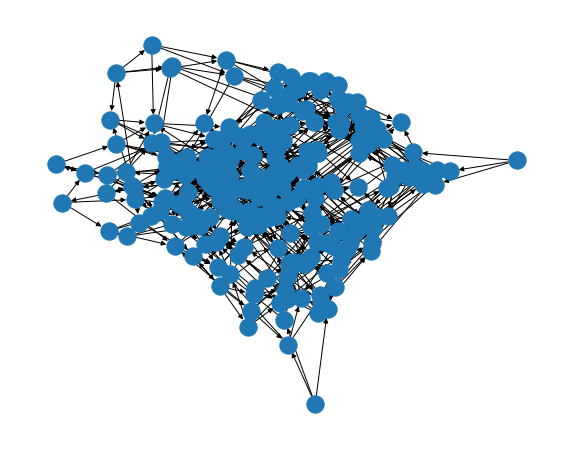

In [156]:
# draw BR graph (without self-loops)
br_graph_ = nx.DiGraph.copy(br_graph4)
br_graph_.remove_edges_from(nx.selfloop_edges(br_graph_))
fig, ax = plt.subplots(figsize=(10,8))
nx.draw_spectral(br_graph_, ax=ax)

#### Compute Transition Matrix from BR graph

In [136]:
# BR Process PARAMETERS
agent_inertias = [0.5]*n_agents

agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))

In [137]:
transition_matrix, jps_dict = transition_matrix_from_br_graph(br_graph4, agent_inertias, joint_policy_space)
transition_matrix # confirmed with simulation of full q-learning algorithm

array([[0.125     , 0.015625  , 0.015625  , ..., 0.0005787 , 0.0005787 ,
        0.0005787 ],
       [0.015625  , 0.125     , 0.015625  , ..., 0.00462963, 0.0005787 ,
        0.0005787 ],
       [0.        , 0.03125   , 0.0625    , ..., 0.00390625, 0.0078125 ,
        0.00390625],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0625    , 0.0625    ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.125     ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0625    ,
        0.0625    ]])

In [138]:
inv_jps_dict = {i: policy for policy, i in jps_dict.items()}
final_state_probs = np.round(np.linalg.matrix_power(transition_matrix, 100), 4)
final_state_probs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Find equilibria according to transition matrix

In [142]:
# find equilibria
print(set(np.where(final_state_probs != 0)[1]))

{130, 131, 4, 132, 8, 136, 10, 138, 139, 140, 142, 12, 154, 32, 160, 162, 163, 36, 164, 38, 166, 40, 167, 42, 168, 44, 170, 46, 171, 172, 174, 178, 182, 183, 184, 186, 187, 202, 224, 226, 227, 230, 231, 232, 106, 234, 235, 242, 246, 250, 251}


In [153]:
inv_jps_dict[202]

((1, 1), (0, 0), (1, 0), (1, 0))

### $N=5$

#### Learn Best-Reply Graph

In [157]:
n_agents = 5

# GAME PARAMS (adjusted for n-agents)
n_Us = [n_actions_const] * n_agents # number of actions per agent (both agents have two actions)
reward_funcs = [gen_reward_i(i) for i in range(n_agents)]
betas = [beta_const]*n_agents # discount factor

# LEARNING PARAMETERS
T = 10000 # length of exploration phase
experimentation_probs = [0.05]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-6]*n_agents # tolerance for suboptimality

In [158]:
br_graph5 = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

100%|████████████████████████████████████████████████████████████████████████████| 1024/1024 [1:24:10<00:00,  4.93s/it]


Draw best-reply graph. It's too large and complicated to make sense of visually at this point.

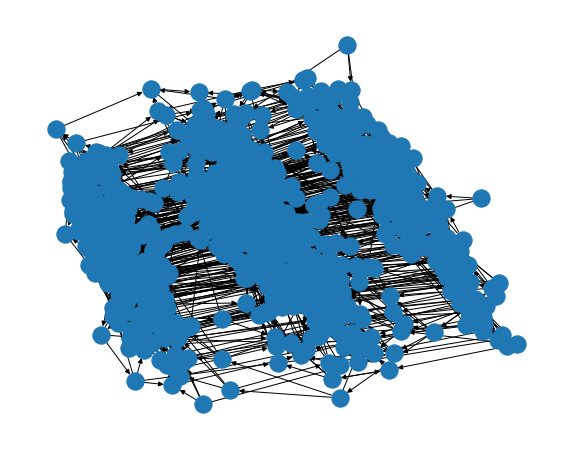

In [159]:
# draw BR graph (without self-loops)
br_graph_ = nx.DiGraph.copy(br_graph5)
br_graph_.remove_edges_from(nx.selfloop_edges(br_graph_))
fig, ax = plt.subplots(figsize=(10,8))
nx.draw_spectral(br_graph_, ax=ax)

#### Compute Transition Matrix from BR Graph

In [160]:
# BR Process PARAMETERS
agent_inertias = [0.5]*n_agents

agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))

In [169]:
transition_matrix, jps_dict = transition_matrix_from_br_graph(br_graph5, agent_inertias, joint_policy_space)
transition_matrix # confirmed with simulation of full q-learning algorithm

array([[0.0625 , 0.03125, 0.     , ..., 0.     , 0.     , 0.     ],
       [0.03125, 0.0625 , 0.03125, ..., 0.     , 0.     , 0.     ],
       [0.     , 0.03125, 0.0625 , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.125  , 0.125  , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.0625 , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.0625 ]])

In [170]:
inv_jps_dict = {i: policy for policy, i in jps_dict.items()}
final_state_probs = np.round(np.linalg.matrix_power(transition_matrix, 100), 4)
final_state_probs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [171]:
# find equilibria
print(set(np.where(final_state_probs != 0)[1]))

{672, 162, 163, 546, 674, 424, 616, 42, 106, 142, 174, 526}


In [174]:
inv_jps_dict[672]

((1, 0), (1, 0), (1, 0), (0, 0), (0, 0))

Note: for $N=5$ learning BR graph took >1 hour. compute time increases geometrically with N.

Note: the learning process finding the best-reply graph will sometimes make mistakes when equilibria are clustered together in policy space, thinking that another equilibrium is better even when it is already at an equilibrium due to stochasticity in learning Q. This can (I think) be fixed by the choice of learning parameters $T$ and $\delta$ 